In [1]:
from pyiron_atomistics import Project
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from numpy import save
import pickle
from scipy.optimize import curve_fit

from mylib import get_surf_plot
# Birch murnaghan fit @ each temperature
from mylib import get_lowestE_with_volume2
from mylib import check_poly_fits_given_temp2

import psutil
print('CPU percent: ', psutil.cpu_percent())
print('Available memory: ', dict(psutil.virtual_memory()._asdict())['available']/1e9, 'Gb')
print('Available memory in percent: ', dict(psutil.virtual_memory()._asdict())['percent'], '%')

CPU percent:  1.9
Available memory:  40.2436096 Gb
Available memory in percent:  80.0 %


In [2]:
# Create a project
project_name = 'W_2'
pr = Project(path=project_name)

In [ ]:
## Print available potentials
dummy_job = pr.create_job(pr.job_type.Lammps, 'dummy_job')
dummy_job.structure = pr.create_ase_bulk('W')
potentials = dummy_job.list_potentials()
for pot in potentials:
    print(pot)

In [4]:
## Target structures
w_bcc = pr.create_ase_bulk(name='W', crystalstructure='bcc',cubic=True
                                ).repeat(4)

# To call info:
# list(fcc_basis.info.keys())[0] 
w_bcc.info = {'bcc':'bcc'}


potential_list = ['2009--Olsson-P-A-T--W--LAMMPS--ipr1',
                  '2019--Chen-Y--W-Ta--LAMMPS--ipr1',
                  'MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000',
                 ]
basis_list = [
    w_bcc
    ]

strain_list = np.around(np.linspace(0.98, 1.06, num=5),decimals=3)

temp_list = [1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100]

# Create BM (birch murnaghan) jobs
### To see if potentials are very very bad or not

In [5]:
def make_energy_job(project, basis, potential, strain_list):
    project_basis = project.create_group(list(basis.info.keys())[0])
    for strain in strain_list:
        strain_structure = basis.copy()
        strain_structure.set_cell(cell=basis.cell*strain**(1/3),
                                    scale_atoms=True)
        
        job_ref = project_basis.create_job(job_type=pr.job_type.Lammps,
                                           job_name='energyjob'+str(strain).replace('.','_'), 
                                           delete_existing_job=True)
        job_ref.structure = strain_structure
        job_ref.potential = potential

        job_ref.calc_static()
        job_ref.run()
    return len(basis)
def energy_volume_pairs(pr):
    volume_lst, energy_lst = zip(*[[job['output/generic/volume'][-1], job['output/generic/energy_pot'][-1]]
                               for job in pr.iter_jobs(convert_to_object=False) if 'energyjob' in job.job_name])
    return volume_lst, energy_lst

In [ ]:
pr_bm = pr.create_group('BM')
murn = pr_bm.create_job(job_type=pr.job_type.Murnaghan, job_name='murn')

bm_data_dict = {}
for potential in potential_list:
    pr_bm_pot = pr_bm.create_group(potential)
    murndata = []
    vols = []
    ens = []
    # Only take hcp and bcc
    for base in basis_list[:2]:
        atom_size = make_energy_job(pr_bm_pot, base, potential, strain_list)
        volume_lst, energy_lst = energy_volume_pairs(pr_bm_pot[list(base.info.keys())[0]])
        volume_lst= [i/atom_size for i in volume_lst]
        energy_lst= [i/atom_size for i in energy_lst]

        [e0, b0, bP, v0], [e0_error, b0_error, bP_error, v0_error] = murn._fit_leastsq(volume_lst=volume_lst,
                                                                                   energy_lst=energy_lst,
                                                                                   fittype='birchmurnaghan')
        murndata.append([e0, b0, bP, v0])
        vols.append(volume_lst)
        ens.append(energy_lst)
        
        bm_data_dict[potential] = (murndata, vols, ens)

In [ ]:
for potential in bm_data_dict.keys():
    plt.figure(figsize=(8,6))
    plt.title(potential)
    labels = [list(base.info.keys())[0] for base in basis_list[:2]]
    for i,j,k, label in zip(*bm_data_dict[potential], labels):
        vol_lst = np.linspace(min(j), max(j), 1000)
        if 'bcc' in label:
            plt.scatter(j, k, marker='x', color='b',zorder=5)
            plt.plot(vol_lst, murn.fit_module.birchmurnaghan_energy(vol_lst, i[0], i[1]/ 160.21766208, i[2], i[3]), label=label)

    plt.xlabel('Volume ($\AA ^ 3$/Atom)')
    plt.ylabel('Energy (eV/Atom)')
    plt.legend()
    plt.show()

### Create Phonon jobs

In [6]:
## Helper functions to create phonopy jobs
def create_lammps_job(project, basis, potential, name, pressure = None):

    job_ref = project.create_job(job_type=pr.job_type.Lammps,
                                 job_name=name)
    job_ref.structure = basis
    job_ref.potential = potential
    
    job_ref.calc_minimize(ionic_energy_tolerance=1e-10,
                          ionic_force_tolerance=1e-12,
                          max_iter=10000,
                          pressure=pressure)
    
    return job_ref

def make_phonopy_job(project, basis, potential):
    pr_phon = project

    ref_job = pr_phon.create_job(pr.job_type.Lammps,'phononjob_ref')
    ref_job.structure = basis.copy()
    ref_job.potential = potential
    
    phonopy_job = pr_phon.create_job(pr.job_type.PhonopyJob,'phononjob')
    phonopy_job.ref_job = ref_job
    phonopy_job.input['primitive_matrix'] = 'auto'
    if 'hd' in list(basis.info.keys())[0]:
        if 'uhd' in list(basis.info.keys())[0]:
            print('displacement=0.9')
            phonopy_job.input['displacement'] = 1.3
        else:
            print('displacement=0.64')
            phonopy_job.input['displacement'] = 0.64
    else:
        print('displacement=0.01')
        phonopy_job.input['displacement'] = 0.01
    phonopy_job.server.cores = 4
    phonopy_job.server.queue = 'cmti'
    phonopy_job.server.run_time = 1000

    return phonopy_job

In [7]:
## Create phonon jobs
for basis in basis_list:
    pr_groupbybas = pr.create_group(list(basis.info.keys())[0])

    for potential in potential_list:
            
        pr_groupbybasandpot = pr_groupbybas.create_group(potential)
        
        for strain in strain_list:
            pr_groupbybaspotstrain = pr_groupbybasandpot.create_group(str(strain).replace('.','_'))
            
            strain_structure = basis.copy()
            strain_structure.set_cell(cell=basis.cell*strain**(1/3),
                                      scale_atoms=True)
            energyjob = create_lammps_job(pr_groupbybaspotstrain, strain_structure,
                                          potential, 'energyjob', pressure = None)
            energyjob.run()
            phononjob = make_phonopy_job(pr_groupbybaspotstrain,
                                           strain_structure, potential)
            
            phononjob.run()

The job energyjob was saved and received the ID: 15850717
displacement=0.01
The job phononjob was saved and received the ID: 15850718
Queue system id:  2434974
The job energyjob was saved and received the ID: 15850719
displacement=0.01
The job phononjob was saved and received the ID: 15850720
Queue system id:  2434975
The job energyjob was saved and received the ID: 15850721
displacement=0.01
The job phononjob was saved and received the ID: 15850722
Queue system id:  2434976
The job energyjob was saved and received the ID: 15850723
displacement=0.01
The job phononjob was saved and received the ID: 15850724
Queue system id:  2434977
The job energyjob was saved and received the ID: 15850725
displacement=0.01
The job phononjob was saved and received the ID: 15850726
Queue system id:  2434978
The job energyjob was saved and received the ID: 15850727
displacement=0.01
The job phononjob was saved and received the ID: 15850728
Queue system id:  2434979
The job energyjob was saved and received

## After running phonon jobs check if everything is allright.

In [8]:
pr_df = pr.job_table()

# Filter energy and phonon jobs
energy_filter = pr_df['job'] == 'energyjob'
phonon_filter = pr_df['job'] == 'phononjob'
pr_df_energy = pr_df[energy_filter]
pr_df_phonon = pr_df[phonon_filter]

print('Total number of jobs: {}'.format(len(pr_df)))
print('Total number of calc_minimize jobs: {}'.format(len(pr_df_energy)))
print('Total number of phonon jobs: {}'.format(len(pr_df_phonon)))
print('Total number of running(!) jobs: {}'.format(len(pr_df[pr_df['status']=='running'])))

Total number of jobs: 45
Total number of calc_minimize jobs: 15
Total number of phonon jobs: 15
Total number of running(!) jobs: 0


/cmmc/u/caras/W_2/bcc/2009--Olsson-P-A-T--W--LAMMPS--ipr1/0_98/phononjob
Scaled distances:  [(0.0, 2.503113230442018), (2.503113230442018, 4.273081569765327), (4.273081569765327, 6.0430499090886345), (6.0430499090886345, 8.210809555200347), (8.210809555200347, 10.378569201311997), (10.378569201311997, 11.630125816533015)]
ARE ALL FREQS POSITIVE:  True


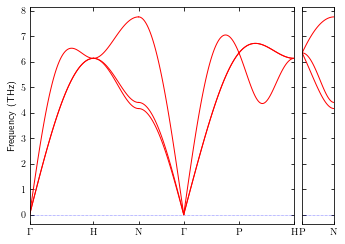

/cmmc/u/caras/W_2/bcc/2019--Chen-Y--W-Ta--LAMMPS--ipr1/0_98/phononjob
Scaled distances:  [(0.0, 2.3401837499133493), (2.3401837499133493, 3.994943548699635), (3.994943548699635, 5.649703347485921), (5.649703347485921, 7.676361924434405), (7.676361924434405, 9.703020501382829), (9.703020501382829, 10.873112376339511)]
ARE ALL FREQS POSITIVE:  True


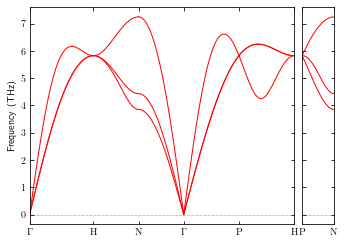

/cmmc/u/caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/0_98/phononjob
Scaled distances:  [(0.0, 2.1602702259855784), (2.1602702259855784, 3.68781195197537), (3.68781195197537, 5.215353677965161), (5.215353677965161, 7.086202572707816), (7.086202572707816, 8.957051467450418), (8.957051467450418, 10.037186580443214)]
ARE ALL FREQS POSITIVE:  True


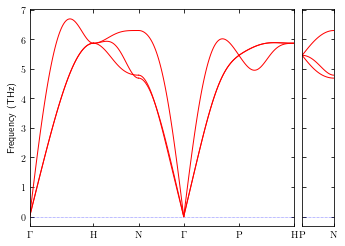

In [9]:
strain_filter = pr_df_phonon['project'].str.contains('/0_98/')
pr_df_phonon_givenstrain = pr_df_phonon[strain_filter]

for id_ in pr_df_phonon_givenstrain['id']:
    job = pr.load_from_jobpath(job_id = id_)
    print(job.path)
    
    job.phonopy.auto_band_structure(plot=True)
    posit = (job.phonopy.get_mesh_dict()['frequencies']>0).all()
    print('ARE ALL FREQS POSITIVE: ',posit)
    plt.show()

### Create tild jobs one by one

In [10]:
def filter_jobs(project, basis_name='', pot_name='', job_name=''):
    '''
    Returns a filtered job table.
    '''
    pr_df = project.job_table()
    basis_filter = pr_df['project'].str.contains(basis_name)
    pot_filter = pr_df['project'].str.contains(pot_name)
    type_filter = pr_df['job']==job_name

    pr_df_ = pr_df[basis_filter & pot_filter & type_filter]
    return pr_df_

In [21]:

basis_name = 'bcc'
pot_name = 'MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000'
job_type = 'phononjob'

In [22]:
filtered_job_table = filter_jobs(pr, basis_name=basis_name, pot_name=pot_name, job_name=job_type)
filtered_job_table

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
24,15850746,finished,W128,phononjob,/phononjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/0_98/,2021-09-19 00:35:51.990558,2021-09-19 00:36:02.803759,10.0,caras@cmti001#4#0/1,PhonopyJob,0.0.1,None,NaN
31,15850749,finished,W128,phononjob,/phononjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/1_0/,2021-09-19 00:35:55.488213,2021-09-19 00:36:04.646797,9.0,caras@cmti001#4#0/1,PhonopyJob,0.0.1,None,NaN
33,15850752,finished,W128,phononjob,/phononjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/1_02/,2021-09-19 00:35:59.051930,2021-09-19 00:36:08.784779,9.0,caras@cmti001#4#0/1,PhonopyJob,0.0.1,None,NaN
52,15850757,finished,W128,phononjob,/phononjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/1_04/,2021-09-19 00:36:07.589962,2021-09-19 00:36:17.152134,9.0,caras@cmti001#4#0/1,PhonopyJob,0.0.1,None,NaN
53,15850759,finished,W128,phononjob,/phononjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/1_06/,2021-09-19 00:36:11.442257,2021-09-19 00:36:21.169409,9.0,caras@cmti001#4#0/1,PhonopyJob,0.0.1,None,NaN


In [23]:
filtered_job_table2 = filter_jobs(pr, basis_name=basis_name, pot_name=pot_name, job_name='energyjob')
filtered_job_table2

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
27,15850745,finished,W128,energyjob,/energyjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/0_98/,2021-09-19 00:35:50.075795,2021-09-19 00:35:50.574961,0.0,caras@cmti001#1,Lammps,0.1,None,NaN
28,15850747,finished,W128,energyjob,/energyjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/1_0/,2021-09-19 00:35:53.691778,2021-09-19 00:35:54.114255,0.0,caras@cmti001#1,Lammps,0.1,None,NaN
47,15850750,finished,W128,energyjob,/energyjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/1_02/,2021-09-19 00:35:57.079026,2021-09-19 00:35:57.536703,0.0,caras@cmti001#1,Lammps,0.1,None,NaN
49,15850754,finished,W128,energyjob,/energyjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/1_04/,2021-09-19 00:36:05.761742,2021-09-19 00:36:06.212166,0.0,caras@cmti001#1,Lammps,0.1,None,NaN
51,15850758,finished,W128,energyjob,/energyjob,/cmmc/u/,caras/W_2/bcc/MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000/1_06/,2021-09-19 00:36:09.329817,2021-09-19 00:36:09.779596,0.0,caras@cmti001#1,Lammps,0.1,None,NaN


In [24]:
## Generate and plot lambdas (integration_points)
# INPUT parameters are also added.
temperature_damping_timescale = 100.
n_lambdas = 12
sampling_period = 25
thermalization_steps = 1000 #1000
convergence_steps = 20000
fe_tol = 1e-3
n_steps = 260000
tild_cores = n_lambdas # if running on the headnode, use 1! Otherwise, set to n_lambdas
queue = 'cmti'
tild_run_time = 208400  # in seconds

def generate_lambdas(N, bias=None):
    """
    A function to generate N points between 0 and 1, with a left, equidistant and right bias.
    bias = 0 makes the points fully left biased. The amount of left bias can be controlled by varying it between 0 and 
        0.49.
    bias = 0.5 keeps the points equidistant.
    bias = 1 makes the points fully right biased. The amount of right bias can be controlled by varying it between 0.51 
        and 1.
    
    """
    factor = bias + 0.5
    lambdas = [0, 1]
    for n in np.arange(N - 2):
        lambdas.append(lambdas[-1] + (lambdas[-1] - lambdas[-2]) / factor)
    lambdas = np.asarray(lambdas)
    lambdas /= lambdas[-1]
    
    return np.around(lambdas, decimals=4)
# we use equidistant bias in new_generate_lambdas
lambdas = generate_lambdas(n_lambdas, bias=0.5)

In [25]:
for id2_,id_ in zip(filtered_job_table2['id'], filtered_job_table['id']):
    job = pr.load_from_jobpath(job_id = id_)
    energyjob = pr.load_from_jobpath(job_id = id2_)
    
    eq_energy = energyjob.output.energy_pot[-1]

    force_constants = job.phonopy.force_constants
    
    tild_project = job.project.create_group('tild_jobs')
    for temperature in temp_list:
        tild_project_at_temp = tild_project.create_group('temp'+str(temperature).replace('.','_')+'K')
        # run the TILD protocol
        tild_ref_job = tild_project_at_temp.create_job(pr.job_type.Lammps, 'ref_job')
        tild_ref_job.potential = pot_name
        tild_ref_job.structure = job.structure.copy()
        tild_ref_job.save()

        tildjob = tild_project_at_temp.create_job(pr.job_type.ProtoHarmTILDPar, 'tildjob')
        tildjob.input.structure = job.structure.copy()
        tildjob.input.temperature = temperature
        tildjob.input.ref_job_full_path = tild_ref_job.path
        tildjob.input.spring_constant = None
        tildjob.input.force_constants = force_constants
        tildjob.input.temperature_damping_timescale = temperature_damping_timescale
        tildjob.input.n_lambdas = n_lambdas
        tildjob.input.sampling_period = sampling_period
        tildjob.input.thermalization_steps = thermalization_steps
        tildjob.input.convergence_check_steps = convergence_steps
        tildjob.input.fe_tol = fe_tol
        tildjob.input.custom_lambdas = lambdas
        tildjob.input.n_steps = n_steps
        
        tildjob.input.eq_energy = eq_energy
        # cluster inputs
        tildjob.server.cores = tild_cores
        tildjob.server.queue = queue
        tildjob.server.run_time = tild_run_time

        # run_job
        tildjob.run()

The job ref_job was saved and received the ID: 15851018
The job tildjob was saved and received the ID: 15851019
Queue system id:  2435070
The job ref_job was saved and received the ID: 15851020
The job tildjob was saved and received the ID: 15851021
Queue system id:  2435071
The job ref_job was saved and received the ID: 15851022
The job tildjob was saved and received the ID: 15851023
Queue system id:  2435072
The job ref_job was saved and received the ID: 15851024
The job tildjob was saved and received the ID: 15851025
Queue system id:  2435073
The job ref_job was saved and received the ID: 15851026
The job tildjob was saved and received the ID: 15851027
Queue system id:  2435074
The job ref_job was saved and received the ID: 15851028
The job tildjob was saved and received the ID: 15851029
Queue system id:  2435075
The job ref_job was saved and received the ID: 15851030
The job tildjob was saved and received the ID: 15851031
Queue system id:  2435076
The job ref_job was saved and rece

### Plot integrands and save free energy surfaces

In [27]:
def plot_integrands(target_pr):
    integrand_dict = {}
    
    target_groups = target_pr.list_groups()
    
    for i in target_groups:
        print(i)
        total_steps = []
        n_samples = []
        standard_errors = []
        plt.figure()       
        temp_groups = target_pr[i]['tild_jobs'].list_groups()
        integrand_dict[i] = []
        for j in temp_groups:
            label = j[4:]
            integrands = target_pr[i]['tild_jobs'][j]['tildjob/output/integrands/i_0']
            lambdas = np.linspace(0,1,num=len(integrands),endpoint=True)
            plt.plot(lambdas,integrands,'o-', label=label )
            integrand_dict[i].append([lambdas, integrands, label.replace('Temp','')+'K'])
            n_samples.append(target_pr[i]['tild_jobs'][j]['tildjob/output/integrands_n_samples/i_0'].mean())
            total_steps.append(target_pr[i]['tild_jobs'][j]['tildjob/output/total_steps/i_0'].mean())
            standard_errors.append(target_pr[i]['tild_jobs'][j]['tildjob/output/tild_free_energy_se'][0]*1000)
        print('Integrands_n_samples: ', n_samples)
        print('total_steps: ',total_steps)
        print('Error free energy (meV): ',standard_errors)
        plt.legend()
        plt.show()
    return integrand_dict

def get_ANH_surface(target_pr, fep=False):
    strain_group_list = target_pr.list_groups()
    vol_arr_anh = np.zeros(len(strain_group_list))
    temp_arr_anh = np.zeros(len(target_pr[strain_group_list[0]+'/tild_jobs'].list_groups()))
    surface_array_anh = np.zeros((len(vol_arr_anh), len(temp_arr_anh)))

    for i,group in enumerate(strain_group_list):
        #print(group)
        e_job = target_pr[group+'/energyjob']
        nu_atoms = e_job.structure.get_number_of_atoms()
        volume_anh = e_job['output/generic/volume'][-1] / nu_atoms
        vol_arr_anh[i] = volume_anh
        temp_groups = target_pr[group+'/tild_jobs'].list_groups()
        U_per_atom = e_job.output.energy_tot[-1] / nu_atoms
        sorted_temp_groups = sorted(temp_groups, key=lambda x: float(x[4:-1]))
        for j,temp_group in enumerate(sorted_temp_groups):
            tild_job_output = target_pr[group+'/tild_jobs/'+temp_group+'/tildjob/output']
            temp_anh = float(temp_group[4:-1].replace('_','.'))
            temp_arr_anh[j] = temp_anh

            p_job = target_pr[group+'/phononjob']
            number_of_atoms_prim = p_job.phonopy.primitive.get_number_of_atoms()

            phonopy_instance_ = deepcopy(p_job.phonopy)
            phonopy_instance_.run_thermal_properties(temperatures=temp_anh,classic=True)
            Fvib_per_atom = phonopy_instance_.get_thermal_properties_dict()['free_energy']/number_of_atoms_prim*0.01036410 #kj/mol
            #import pdb;pdb.set_trace()
            if fep==False:
                A_anh = tild_job_output['tild_free_energy_mean'][-1] / nu_atoms
            else:
                A_anh = tild_job_output['fep_free_energy_mean'][-1] / nu_atoms # eV in raw
            A_tot = Fvib_per_atom + U_per_atom + A_anh #
            print(group,temp_group, Fvib_per_atom , U_per_atom , A_anh )
            surface_array_anh[i][j] = A_tot
    return temp_arr_anh, vol_arr_anh, surface_array_anh

def get_all_ANH_surface(basis_list, potential_list, fep=False):
    target_folder = 'surfaces_'+project_name
    basis_names = [list(i.info.keys())[0]  for i in basis_list]

    for bb in basis_names:
        for pp in potential_list:
            print('BASIS: {}, POTENTIAL: {}'.format(bb,pp))
            try:
                target_pr = pr[bb]
                target_pr = target_pr[pp]
                integrand_dict = plot_integrands(target_pr)
                anh_surface = get_ANH_surface(target_pr, fep=fep)
                if not fep:
                    name = target_folder + '/' + bb +'-'+pp+'-'+'TILD'+'.npy'
                else:
                    name = target_folder + '/' + bb +'-'+pp+'-'+'FEP'+'.npy'
                with open(name, 'wb') as f:
                    np.save(f, anh_surface[1])
                    np.save(f, anh_surface[0])
                    np.save(f, anh_surface[2])
            except:
                print('Could not deal with basis: {}, potential: {}'.format(bb,pp))

BASIS: bcc, POTENTIAL: 2009--Olsson-P-A-T--W--LAMMPS--ipr1
0_98
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.4416973561242599, 1.6038296101714964, 1.7736646487636851, 1.9373246990812039, 2.12339647699117, 2.311248843972245, 2.5096682772964094, 2.722451193967834]


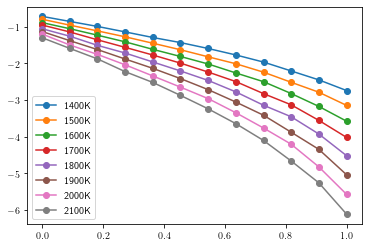

1_0
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.4848358727039197, 1.6582790153266922, 1.8297211050720603, 2.017148388499284, 2.195476353435735, 2.380050580546487, 2.589243896062985, 2.7936052262825335]


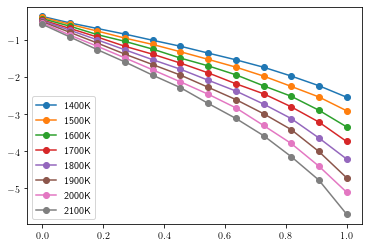

1_02
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.5564267073833944, 1.7394439255266323, 1.908329045553397, 2.1056616175120357, 2.285182967375049, 2.4809845110646127, 2.6829970572104442, 2.903399795264339]


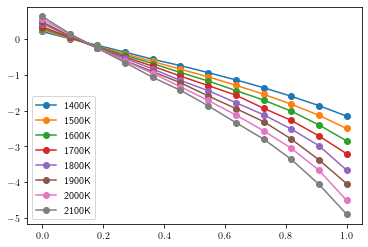

1_04
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.6615767521889047, 1.8429709723138168, 2.0304065369226225, 2.234777669853302, 2.4405898068891716, 2.648389218590693, 2.8628363803273342, 3.0825392613672316]


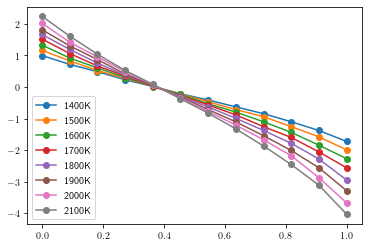

1_06
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.8249123630285142, 2.0296604056242042, 2.2191943121600946, 2.4234157696979275, 2.6389955774014937, 2.8804264603224343, 3.1000037269085325, 3.329874957904049]


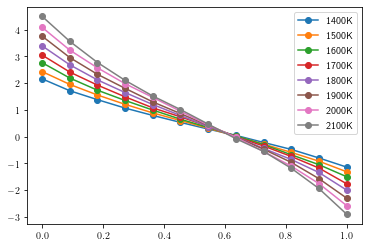

0_98 temp1400K [-0.6396107] -8.893518543497734 -0.012370348807079141
0_98 temp1500K [-0.71205082] -8.893518543497734 -0.01402771583079244
0_98 temp1600K [-0.78621567] -8.893518543497734 -0.015701746304424925
0_98 temp1700K [-0.8619973] -8.893518543497734 -0.017419593141802546
0_98 temp1800K [-0.93930048] -8.893518543497734 -0.019293076143983987
0_98 temp1900K [-1.01804061] -8.893518543497734 -0.02121984887308819
0_98 temp2000K [-1.09814198] -8.893518543497734 -0.023234379011355336
0_98 temp2100K [-1.17953646] -8.893518543497734 -0.02530888816778782
1_0 temp1400K [-0.65773933] -8.90000479019 -0.010253241897967209
1_0 temp1500K [-0.73147436] -8.90000479019 -0.01157214570085241
1_0 temp1600K [-0.80693411] -8.90000479019 -0.013012756856612467
1_0 temp1700K [-0.88401064] -8.90000479019 -0.014429256745516015
1_0 temp1800K [-0.96260873] -8.90000479019 -0.015989081914036987
1_0 temp1900K [-1.04264376] -8.90000479019 -0.017518452489641515
1_0 temp2000K [-1.12404002] -8.90000479019 -0.0191500254

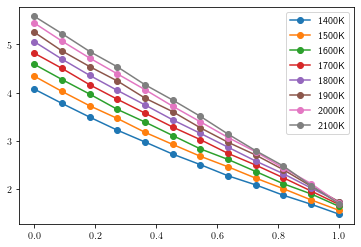

1_0
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.7037476040751425, 1.8405937148344889, 1.969803795181102, 2.114636787313473, 2.2470277432811807, 2.3901394235934763, 2.536194337676358, 2.6804542238884506]


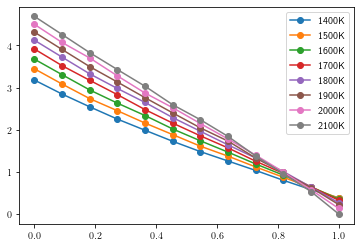

1_02
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.8167939452671646, 1.9842638868866476, 2.1492795219568332, 2.306769069402392, 2.4766686069854957, 2.6300177853659306, 2.8037166911017204, 2.9913412369504546]


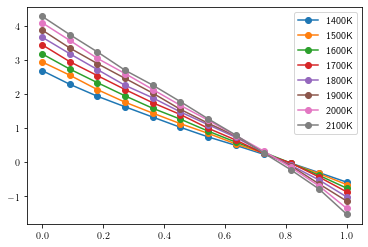

1_04
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [2.016746598750972, 2.1957366574696886, 2.380090747863944, 2.5720351535473416, 2.7560505587616357, 2.9657329017318435, 3.156078426788955, 3.3593859024269364]


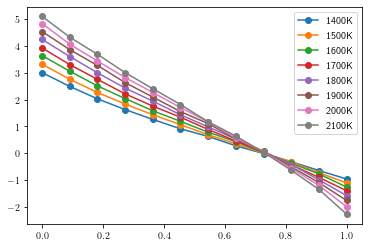

1_06
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [2.2700764874951944, 2.474881176197693, 2.6775664873953553, 2.8964255446401164, 3.108827082340889, 3.31961031016152, 3.5193314735368104, 3.748445288578015]


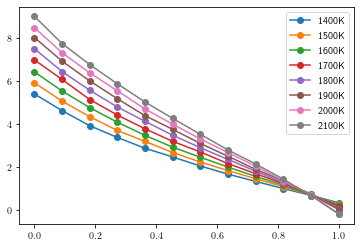

0_98 temp1400K [-0.6569831] -8.890140516680624 0.02084399510789017
0_98 temp1500K [-0.73066412] -8.890140516680624 0.022285106692680533
0_98 temp1600K [-0.80606985] -8.890140516680624 0.023645841553895323
0_98 temp1700K [-0.88309236] -8.890140516680624 0.024900963211483548
0_98 temp1800K [-0.96163644] -8.890140516680624 0.02598109661697831
0_98 temp1900K [-1.04161745] -8.890140516680624 0.026992529056179042
0_98 temp2000K [-1.1229597] -8.890140516680624 0.02790741331742489
0_98 temp2100K [-1.20559508] -8.890140516680624 0.028570646257244498
1_0 temp1400K [-0.66711271] -8.89962476773172 0.01300284205853686
1_0 temp1500K [-0.74151727] -8.89962476773172 0.01409382651443239
1_0 temp1600K [-0.81764654] -8.89962476773172 0.015077975832992866
1_0 temp1700K [-0.8953926] -8.89962476773172 0.0160410226397682
1_0 temp1800K [-0.97466022] -8.89962476773172 0.01687317984374042
1_0 temp1900K [-1.05536477] -8.89962476773172 0.017540823635490685
1_0 temp2000K [-1.13743057] -8.89962476773172 0.018236958

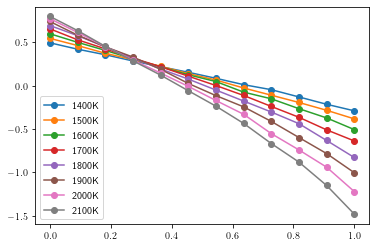

1_0
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [0.9692058751541377, 1.0961070606685135, 1.2269555557942082, 1.3690910558725953, 1.5085183949454817, 1.675937759347705, 1.8457971447906592, 2.0261958141043626]


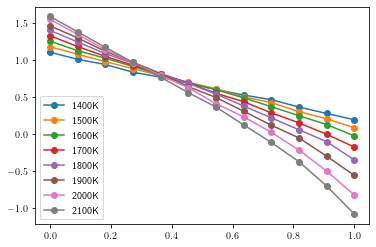

1_02
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.0259324882292182, 1.1597947475927157, 1.308447129536489, 1.473256731381089, 1.6422672367059499, 1.8324631251572463, 2.007720469513962, 2.2043819750772413]


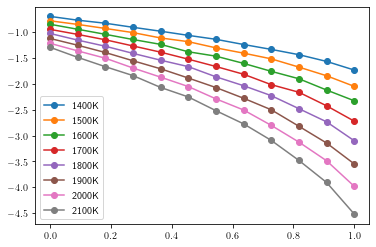

1_04
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.144385394135149, 1.3050062209052011, 1.4661138756867265, 1.6572047659984082, 1.843328964260635, 2.04200659056591, 2.241634095249302, 2.473780004444685]


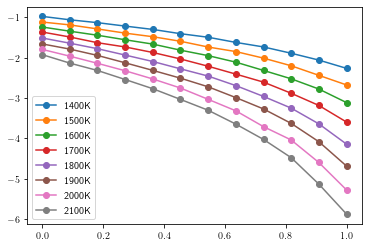

1_06
Integrands_n_samples:  [10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0, 10361.0]
total_steps:  [260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0, 260000.0]
Error free energy (meV):  [1.4373817752939562, 1.6207217899045507, 1.8045452844299203, 2.0348925044761845, 2.2526575380708467, 2.456953354590798, 2.7225336243892024, 2.9970437303827597]


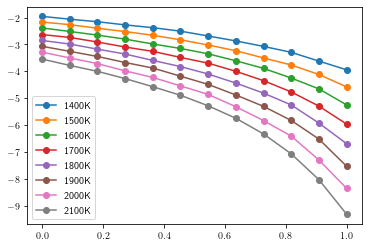

0_98 temp1400K [-0.65237051] -8.810485899104922 0.0008681986601021205
0_98 temp1500K [-0.72572206] -8.810485899104922 0.0007186617210513644
0_98 temp1600K [-0.80079832] -8.810485899104922 0.0005485265860373684
0_98 temp1700K [-0.87749136] -8.810485899104922 0.00025904658913802577
0_98 temp1800K [-0.95570596] -8.810485899104922 -4.904750930379107e-05
0_98 temp1900K [-1.0353575] -8.810485899104922 -0.0005129205080526413
0_98 temp2000K [-1.11637029] -8.810485899104922 -0.0010428199869791013
0_98 temp2100K [-1.19867619] -8.810485899104922 -0.00161642786818377
1_0 temp1400K [-0.66914162] -8.83441175834789 0.005079330211807088
1_0 temp1500K [-0.7436911] -8.83441175834789 0.005068031511199925
1_0 temp1600K [-0.8199653] -8.83441175834789 0.004998254613020744
1_0 temp1700K [-0.89785628] -8.83441175834789 0.004757347333177092
1_0 temp1800K [-0.97726882] -8.83441175834789 0.004570272073352801
1_0 temp1900K [-1.0581183] -8.83441175834789 0.0041941538212886004
1_0 temp2000K [-1.14032902] -8.8344117

In [28]:
get_all_ANH_surface(basis_list, potential_list, fep=False)

### Plot free en diff

In [29]:
import os
def get_plot(folder, surface_file):
    path = str(os.path.join(folder, surface_file))
    with open(path, 'rb') as f:
        vol_arr = np.load(f)
        temp_arr = np.load(f)
        surf_arr = np.load(f)
       
    get_surf_plot(temp_arr, vol_arr, surf_arr, figure_name='surf', save=False)
    check_poly_fits_given_temp2(temp_array=temp_arr, vol_array=vol_arr, surface_array=surf_arr, temp_index=6)
    a=get_lowestE_with_volume2(temp_arr, vol_arr, surf_arr, residuals=False)
    plt.figure()
    plt.plot(temp_arr, a[1], 'o-')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Free energy (ev/atom)')
    plt.show()
    return temp_arr, a[1]

t_exp_bcc = np.array([1400., 1500., 1600., 1700., 1800., 1900., 2000., 2100.])
s_exp_bcc = np.array([73.09724801, 75.09868911, 77.0000797 , 78.8156026 , 80.55723782, 82.23523655, 83.85847427, 85.43471813])

t_el_bcc = np.array([1400., 1500., 1600., 1700., 1800., 1900., 2000., 2100.])
s_el_bcc = np.array([1.48758403, 1.61066728, 1.73525123, 1.86134957, 1.98901491, 2.11833053, 2.24940271, 2.3823539 ])


2009--Olsson-P-A-T--W--LAMMPS--ipr1
Residual of the fit:  [4.24571965e-05 3.27499675e+00 5.22877582e-01 2.45476552e-03]


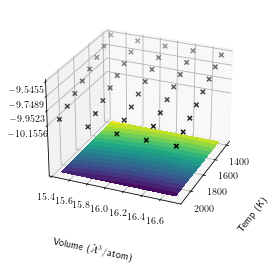

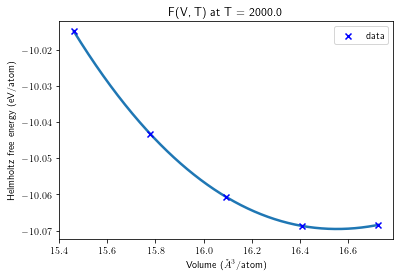

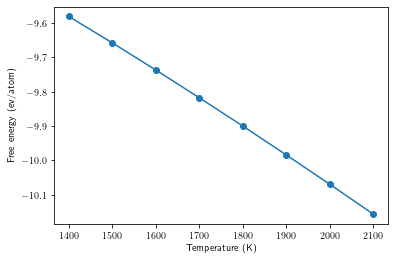

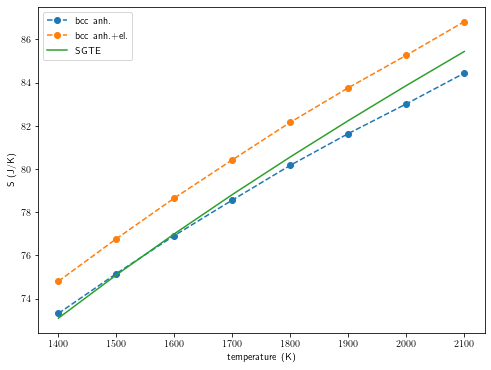

In [31]:
print("2009--Olsson-P-A-T--W--LAMMPS--ipr1")

t_bcc, f_bcc = get_plot('surfaces_W_2', 'bcc-2009--Olsson-P-A-T--W--LAMMPS--ipr1-TILD.npy')
s_bcc = -np.gradient(f_bcc, t_bcc, edge_order=2) * 96487  # J per K


plt.figure(figsize=(8,6))
plt.plot(t_bcc, s_bcc,'o--', label='bcc anh.')
plt.plot(t_bcc, s_bcc+s_el_bcc,'o--', label='bcc anh.+el.')
plt.plot(t_exp_bcc, s_exp_bcc, label='SGTE')
plt.ylabel('S (J/K)')
plt.xlabel('temperature (K)')
plt.legend()
plt.show()

2019--Chen-Y--W-Ta--LAMMPS--ipr1
Residual of the fit:  [3.61365016e-06 2.79306942e-01 4.00760925e-02 1.75990244e-04]


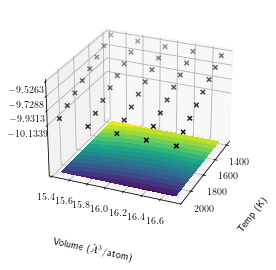

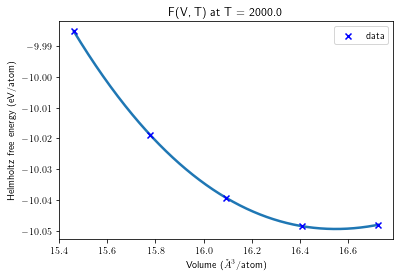

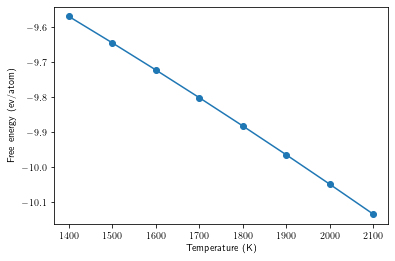

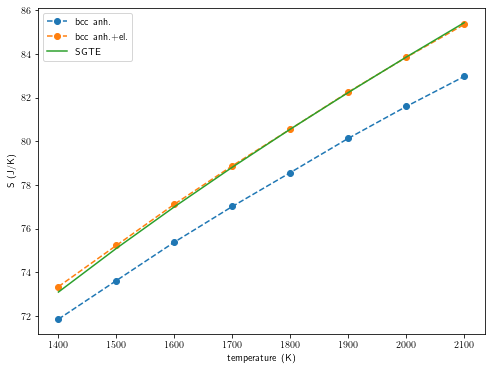

In [32]:
print("2019--Chen-Y--W-Ta--LAMMPS--ipr1")

t_bcc, f_bcc = get_plot('surfaces_W_2', 'bcc-2019--Chen-Y--W-Ta--LAMMPS--ipr1-TILD.npy')
s_bcc = -np.gradient(f_bcc, t_bcc, edge_order=2) * 96487  # J per K


plt.figure(figsize=(8,6))
plt.plot(t_bcc, s_bcc,'o--', label='bcc anh.')
plt.plot(t_bcc, s_bcc+s_el_bcc,'o--', label='bcc anh.+el.')
plt.plot(t_exp_bcc, s_exp_bcc, label='SGTE')
plt.ylabel('S (J/K)')
plt.xlabel('temperature (K)')
plt.legend()
plt.show()

MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000
Residual of the fit:  [9.06624202e-06 3.77193090e-01 3.06421867e-02 4.12640726e-04]


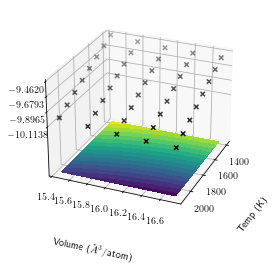

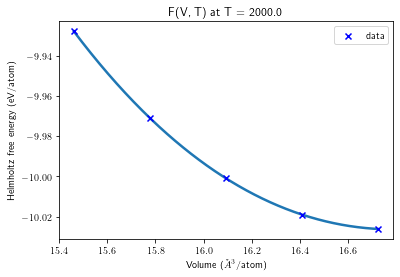

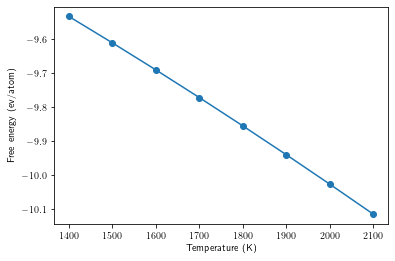

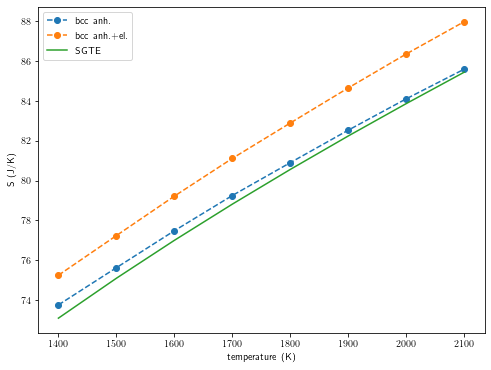

In [34]:
print("MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000")

t_bcc, f_bcc = get_plot('surfaces_W_2', 'bcc-MEAM_LAMMPS_Lenosky_2017_W__MO_999198119251_000-TILD.npy')
s_bcc = -np.gradient(f_bcc, t_bcc, edge_order=2) * 96487  # J per K


plt.figure(figsize=(8,6))
plt.plot(t_bcc, s_bcc,'o--', label='bcc anh.')
plt.plot(t_bcc, s_bcc+s_el_bcc,'o--', label='bcc anh.+el.')
plt.plot(t_exp_bcc, s_exp_bcc, label='SGTE')
plt.ylabel('S (J/K)')
plt.xlabel('temperature (K)')
plt.legend()
plt.show()